In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import pprint
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["xtick.labelsize"] = 24
plt.rcParams["ytick.labelsize"] = 24

os.chdir('./GNNsteal_original/MEA_taxonomy')

In [2]:
datasets = [
    '2025-01-18_23-43-40/coauthorcs',
    '2025-01-18_23-43-40/coauthorphysics', 
    '2025-01-18_23-43-40/amazoncomputer',
    '2025-01-18_23-43-40/amazonphoto',
    '2025-01-21_04-14-31/cora_full',
    '2025-01-22_15-47-10/dblp'
    ]

cega_results = [
    '2025-01-27_04-48-28/coauthorcs',
    '2025-01-27_04-48-28/coauthorphysics',
    '2025-01-27_04-48-28/amazonphoto',
    '2025-01-27_04-48-28/amazoncomputer',
    '2025-01-27_13-17-33/cora_full',
    '2025-01-27_04-48-28/dblp'  
]

datasets_mapping = {
    'cora': 'Cora',
    'citeseer': 'Citeseer',
    'pubmed': 'PubMed',
    'amazonphoto': 'AmazonPhoto',
    'amazoncomputer': 'AmazonComputer',
    'coauthorcs': 'CoAuthorCS',
    'coauthorphysics': 'CoAuthorPhysics',
    'wiki': 'Wiki',
    'amazonrating': 'AmazonRating',
    'question': 'Question',
    'roman':'Roman',
    'cora_full': 'Cora full',
    'flickr': 'Flickr',
    'dblp': 'DBLP'
}

datasets_mapping_adj = {
    'cora': 'Cora',
    'citeseer': 'Citeseer',
    'pubmed': 'PubMed',
    'amazonphoto': 'AmzP',
    'amazoncomputer': 'AmzC',
    'coauthorcs': 'CoCS',
    'coauthorphysics': 'CoP',
    'wiki': 'Wiki',
    'amazonrating': 'AmazonRating',
    'question': 'Question',
    'roman':'Roman',
    'cora_full': 'Cora_Full',
    'flickr': 'Flickr',
    'dblp': 'DBLP'
}

color_mapping = {
    'GRAIN(NN-D)': '#1f77b4',
    'GRAIN(ball-D)': '#ff7f0e',
    'Random': '#9467bd',
    'AGE': '#d62728',
    'CEGA': '#2ca02c',
}

selection_order = [
    'GRAIN(NN-D)', 
    'GRAIN(ball-D)', 
    'Random', 
    'AGE', 
    'CEGA'
    ]

selection_mapping = {
    'grainnnd': 'GRAIN(NN-D)',
    'grain_nnd': 'GRAIN(NN-D)',
    'grainball': 'GRAIN(ball-D)',
    'grain_ball': 'GRAIN(ball-D)',
    'nnd': 'GRAIN(NN-D)',
    'ball': 'GRAIN(ball-D)',
    'random': 'Random',
    'age': 'AGE',
    'cega': 'CEGA',
}

## Plot1: Accuracy, Fidelity, F1

2025-01-18_23-43-40/coauthorcs
2025-01-18_23-43-40/coauthorphysics
2025-01-18_23-43-40/amazoncomputer
2025-01-18_23-43-40/amazonphoto
2025-01-21_04-14-31/cora_full
2025-01-22_15-47-10/dblp


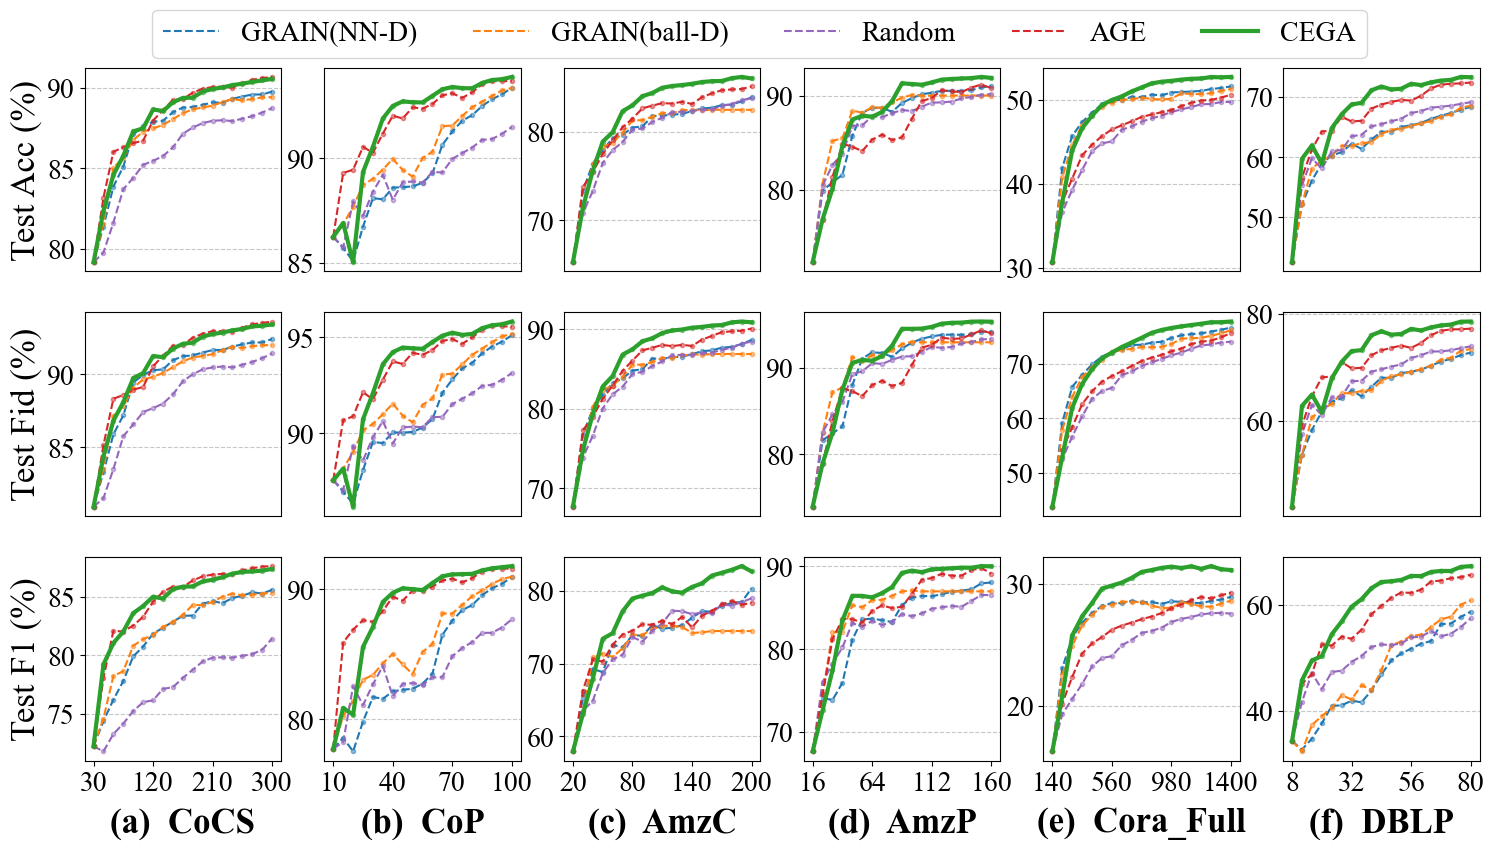

done


In [3]:
def read_file(file_path):
    data = pd.read_csv(file_path, header=None)
    names = ['Num Node', 'Selection', 'Accuracy', 'Fidelity', 'F1']
    data.columns = names
    data = data.iloc[:-2,:]
    return data

fig, axes = plt.subplots(3, len(datasets), figsize=(len(datasets)*3, len(datasets)*1.5))
all_handles = []  # To collect legend handles
annotation_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g','h']  # Labels for subfigures

for idx, dataset_name in enumerate(datasets):
    print(dataset_name)
    # Accuracy plot (first row of subplots)
    file_path = f'./output/{dataset_name}/'
    files = os.listdir(file_path)
    data = pd.DataFrame()

    for f in files:
        if f[:3] == 'log':
            seed = int(f.split('_')[2][0])
            node_selection = f.split('_')[1]
            
            dt = read_file(file_path + f)
            dt['Seed'] = seed
            dt['Selection'] = selection_mapping.get(node_selection, node_selection)  # Map to human-readable names
            data = pd.concat([data, dt])

    # add CEGA
    temp = dataset_name.split('/')[1]
    file_path = ['./output/'+element+'/' for element in cega_results if temp in element]
    if file_path:
        file_path = file_path[0]
        if os.path.exists(file_path):
            files = os.listdir(file_path)
            for f in files:
                if f[:3] == 'log':
                    seed = int(f.split('_')[2][0])
                    node_selection = f.split('_')[1]
                    
                    dt = read_file(file_path + f)
                    dt['Seed'] = seed
                    dt['Selection'] = selection_mapping.get(node_selection, node_selection)  # Map to human-readable names
                    data = pd.concat([data, dt])

    df = pd.DataFrame(data).sort_values(by=['Seed', 'Num Node'])

    ax_acc = axes[0, idx]  # First row for Accuracy

    for selection in selection_order:
        selection_data = df[df['Selection'] == selection]
        if selection_data.empty:
            continue 

        grouped_data = selection_data.groupby('Num Node')['Accuracy'].agg(['mean', 'std']).reset_index()

        if selection == 'CEGA':
            handle, = ax_acc.plot(grouped_data['Num Node'], grouped_data['mean']*100, label=selection, linestyle='-', linewidth=3, color=color_mapping[selection])
        else:
            handle, = ax_acc.plot(grouped_data['Num Node'], grouped_data['mean']*100, label=selection, color=color_mapping[selection], linestyle='dashed')

        ax_acc.plot(grouped_data['Num Node'], grouped_data['mean']*100, '.', color=color_mapping[selection], alpha = 0.5)

        if idx == 0:  # Collect legend handles from the first column
            all_handles.append(handle)

    ax_acc.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax_acc.tick_params(axis='both', labelsize=20)
    c = grouped_data['Num Node'].min() // 2
    xticks = list(range(2 * c, grouped_data['Num Node'].max() + 1, 6 * c))
    ax_acc.set_xticks([]) # 
    
    if idx == 0: 
        ax_acc.set_ylabel('Test Acc (%)', fontsize=25)

    # Fidelity plot (second row of subplots)
    ax_fid = axes[1, idx]  # Second row for Fidelity

    for selection in selection_order:
        selection_data = df[df['Selection'] == selection]
        if selection_data.empty:
            continue  # Skip if selection is not in the current dataset

        grouped_data = selection_data.groupby('Num Node')['Fidelity'].agg(['mean', 'std']).reset_index()

        if selection == 'CEGA':
            ax_fid.plot(grouped_data['Num Node'], grouped_data['mean']*100, label=selection, linestyle='-', linewidth=3, color=color_mapping[selection])
        else:
            ax_fid.plot(grouped_data['Num Node'], grouped_data['mean']*100, label=selection, color=color_mapping[selection], linestyle='dashed')

        ax_fid.plot(grouped_data['Num Node'], grouped_data['mean']*100, '.', color=color_mapping[selection], alpha = 0.5)

    ax_fid.grid(True, axis='y', linestyle='--', alpha=0.7)
    # ax_fid.set_xlabel('Labeling budget', fontsize=20)
    ax_fid.tick_params(axis='both', labelsize=20)
    ax_fid.set_xticks([])  

    if idx == 0:  # Only label Y-axis on the first plot for fidelity row
        ax_fid.set_ylabel('Test Fid (%)', fontsize=25, fontweight='normal')

# -------
    # F1 plot (second row of subplots)
    ax_fid = axes[2, idx]  # Second row for Fidelity

    for selection in selection_order:
        selection_data = df[df['Selection'] == selection]
        if selection_data.empty:
            continue  # Skip if selection is not in the current dataset

        grouped_data = selection_data.groupby('Num Node')['F1'].agg(['mean', 'std']).reset_index()

        if selection == 'CEGA':
            ax_fid.plot(grouped_data['Num Node'], grouped_data['mean']*100, label=selection, color=color_mapping[selection], linestyle='-', linewidth=3)
        else:
            ax_fid.plot(grouped_data['Num Node'], grouped_data['mean']*100, label=selection, color=color_mapping[selection], linestyle='dashed')

        ax_fid.plot(grouped_data['Num Node'], grouped_data['mean']*100, '.', color=color_mapping[selection], alpha = 0.5)

    ax_fid.grid(True, axis='y', linestyle='--', alpha=0.7)
    # ax_fid.set_xlabel('Labeling budget', fontsize=20)
    ax_fid.tick_params(axis='both', labelsize=20)
    ax_fid.set_xticks(xticks)  

    if idx == 0:  # Only label Y-axis on the first plot for fidelity row
        ax_fid.set_ylabel('Test F1 (%)', fontsize=25, fontweight='normal')
# -------
        
    dataset_name = dataset_name.split('/')[1]
    ax_fid.annotate(f'({annotation_labels[idx]})  {datasets_mapping_adj[dataset_name]}', xy=(0.5, -0.35), xycoords='axes fraction', ha='center', fontsize=25, fontweight='bold')

plt.subplots_adjust(hspace=0.2, wspace=0.22)
fig.legend(all_handles, selection_order, 
           loc='upper center', fontsize=20, 
           bbox_to_anchor=(0.5, 0.96),
           ncol=len(selection_order))

# plt.tight_layout(rect=[0.0, 0.0, 1, 0.95])   # Adjust layout to fit legend
plt.savefig('./output/accuracy_fidelity.pdf', format='pdf', bbox_inches='tight')
plt.show()

print('done')


## Table

In [4]:
results = {method: {datasets_mapping[dataset.split('/')[-1]]: "N/A" for dataset in datasets} for method in ['Random', 'AGE', 'GRAIN(NN-D)', 'GRAIN(ball-D)', 'CEGA']}

for idx, dataset_name in enumerate(datasets):
    formatted_dataset_name = datasets_mapping[dataset_name.split('/')[-1]]
    
    file_path = f'./output/{dataset_name}/'
    files = os.listdir(file_path)
    data = pd.DataFrame()

    for f in files:
        if f[:3] == 'log':
            seed = int(f.split('_')[2][0])
            node_selection = f.split('_')[1]
            dt = read_file(file_path + f)
            dt['Seed'] = seed
            dt['Selection'] = selection_mapping.get(node_selection, node_selection)
            data = pd.concat([data, dt])

    # Add CEGA results
    temp = dataset_name.split('/')[1]
    file_path = ['./output/' + element + '/' for element in cega_results if temp in element]
    if file_path:
        file_path = file_path[0]
        if os.path.exists(file_path):
            files = os.listdir(file_path)
            for f in files:
                if f[:3] == 'log':
                    seed = int(f.split('_')[2][0])
                    node_selection = f.split('_')[1]
                    dt = read_file(file_path + f)
                    dt['Seed'] = seed
                    dt['Selection'] = selection_mapping.get(node_selection, node_selection)
                    data = pd.concat([data, dt])

    df = pd.DataFrame(data).sort_values(by=['Seed', 'Num Node'])

    for selection in selection_order:
        selection_data = df[df['Selection'] == selection]
        if selection_data.empty:
            continue 

        grouped_data = selection_data.groupby('Num Node')['Accuracy'].agg(['mean', 'std']).reset_index()
        
        # Save mean and std for the largest "Num Node"
        if not grouped_data.empty:
            final_mean = np.round(grouped_data.iloc[-1]['mean']*100, 2)
            final_std = np.round(grouped_data.iloc[-1]['std']*100, 1)
            results[selection][formatted_dataset_name] = f"{final_mean} ±{final_std}"

# Create a DataFrame with methods as rows and datasets as columns
df_results = pd.DataFrame(results).T  # Transpose to switch rows and columns
df_results = df_results.reindex(selection_order)  # Reorder rows explicitly
df_results.index.name = 'Method'

# Export the DataFrame as a CSV file
csv_file_path = './output/results_table.csv'
df_results.to_csv(csv_file_path, index=True)

print(f"Results table saved to {csv_file_path}")

# Write Latex file
latex_file_path = './output/results_table.tex'

with open(latex_file_path, 'w') as f:
    f.write(r"""\begin{table*}[ht]
\centering
\caption{Test accuracy on different datasets using 20C labeled nodes.}
\label{tab:test_accuracy}
\begin{tabular}{l""" + "c" * len(df_results.columns) + r"""}
\toprule
""")

    column_names = df_results.columns.tolist()  # Get column names
    latex_header = " & ".join([f"\\textbf{{{col}}}" for col in column_names])  # Format for LaTeX
    
    f.write(f"\\textbf{{Method}} & {latex_header} \\\\\n\\midrule\n")

    for method, row in df_results.iterrows():
        row_str = " & ".join(row.values)  # Join row values into LaTeX-compatible string
        f.write(f"{method} & {row_str} \\\\\n")

    f.write(r"""\bottomrule
\end{tabular}
\end{table*}
""")

print(f"LaTeX table saved to {latex_file_path}")


Results table saved to ./output/results_table.csv
LaTeX table saved to ./output/results_table.tex


In [5]:
results = {metric: {method: {datasets_mapping[dataset.split('/')[-1]]: "N/A" for dataset in datasets} 
                    for method in ['Random', 'AGE', 'GRAIN(NN-D)', 'GRAIN(ball-D)', 'CEGA']}
           for metric in ['Accuracy', 'Fidelity', 'F1']}

for metric in ['Accuracy', 'Fidelity', 'F1']:
    for idx, dataset_name in enumerate(datasets):
        formatted_dataset_name = datasets_mapping[dataset_name.split('/')[-1]]
        
        file_path = f'./output/{dataset_name}/'
        files = os.listdir(file_path)
        data = pd.DataFrame()

        for f in files:
            if f.startswith('log'):
                seed = int(f.split('_')[2][0])
                node_selection = f.split('_')[1]
                dt = read_file(file_path + f)
                dt['Seed'] = seed
                dt['Selection'] = selection_mapping.get(node_selection, node_selection)
                data = pd.concat([data, dt])

        # Add CEGA results
        temp = dataset_name.split('/')[1]
        cega_file_path = ['./output/' + element + '/' for element in cega_results if temp in element]
        if cega_file_path:
            cega_file_path = cega_file_path[0]
            if os.path.exists(cega_file_path):
                files = os.listdir(cega_file_path)
                for f in files:
                    if f.startswith('log'):
                        seed = int(f.split('_')[2][0])
                        node_selection = f.split('_')[1]
                        dt = read_file(cega_file_path + f)
                        dt['Seed'] = seed
                        dt['Selection'] = selection_mapping.get(node_selection, node_selection)
                        data = pd.concat([data, dt])

        df = pd.DataFrame(data).sort_values(by=['Seed', 'Num Node'])

        for selection in selection_order:
            selection_data = df[df['Selection'] == selection]
            if selection_data.empty:
                continue 

            grouped_data = selection_data.groupby('Num Node')[metric].agg(['mean', 'std']).reset_index()
            
            # Save mean and std for the largest "Num Node"
            if not grouped_data.empty:
                final_mean = np.round(grouped_data.iloc[-1]['mean'] * 100, 2)
                final_std = np.round(grouped_data.iloc[-1]['std'] * 100, 1)
                results[metric][selection][formatted_dataset_name] = f"{final_mean:.2f} ±{final_std:.1f}"


In [6]:
datasets_mapping_adj = {
    'cora': 'Cora',
    'citeseer': 'Citeseer',
    'pubmed': 'PubMed',
    'amazonphoto': 'AmzP',
    'amazoncomputer': 'AmzC',
    'coauthorcs': 'CoCS',
    'coauthorphysics': 'CoP',
    'wiki': 'Wiki',
    'amazonrating': 'AmazonRating',
    'question': 'Question',
    'roman': 'Roman',
    'cora_full': 'Cora_Full',
    'flickr': 'Flickr',
    'dblp': 'DBLP'}

In [7]:
# Generate LaTeX table with updated dataset abbreviations and explanation in the caption
latex_file_path = './output/results_table_combined.tex'

with open(latex_file_path, 'w') as f:
    f.write(r"""\begin{table*}[ht]
\centering
\caption{Test accuracy, fidelity, and F1 score on different datasets using 20C labeled nodes. Dataset abbreviations: CoCS (CoAuthorCS), CoP (CoAuthorPhysics), AmzC (Amazon Computer), AmzP (Amazon Photo), Cora full, and DBLP. All numerical values are reported in percentage, and the best values for each dataset are marked in bold.}
\label{tab:test_metrics_combined}
\begin{tabular}{ll""" + "c" * len(datasets) + r"""}
\toprule
 &  & """ + " & ".join([f"\\textbf{{{datasets_mapping_adj[dataset.split('/')[-1]]}}}" for dataset in datasets]) + r""" \\
\midrule
""")

    for metric in ['Accuracy', 'Fidelity', 'F1']:
        df_results = pd.DataFrame(results[metric]).T  # Transpose for proper orientation
        df_results = df_results.reindex(selection_order)  # Ensure methods are in correct order
        df_results.index.name = 'Method'

        # Identify the best value per column
        best_values = df_results.apply(lambda col: col.apply(
            lambda x: float(x.split(' ±')[0]) if x != 'N/A' else -float('inf')).idxmax())
        
        # Write rows for the metric block
        f.write(rf"\multirow{{{len(selection_order)}}}{{*}}{{\textbf{{{metric}}}}} ")
        for i, (method, row) in enumerate(df_results.iterrows()):
            metric_label = "" if i > 0 else ""  # Add the metric label only once for the first row
            method_label = f"\\textbf{{{method}}}"  # Add bold text to method name
            row_str = " & ".join(
                [f"\\textbf{{{val.split(' ±')[0]}}} ±{val.split(' ±')[1]}" if val != 'N/A' and method == best_values[col] 
                 else val for col, val in row.items()])
            f.write(f"{metric_label} & {method_label} & {row_str} \\\\\n")
        f.write(r"\midrule\n")

    f.write(r"""\bottomrule
\end{tabular}
\end{table*}
""")

print(f"LaTeX table saved to {latex_file_path}")


LaTeX table saved to ./output/results_table_combined.tex


## Gaps

#### Accuracy gap vs Fidelity gap

In [8]:
os.chdir('./GNNsteal_original/MEA_taxonomy')
datasets_netfull = {
    'coauthorcs':'2025-01-25_21-34-13/coauthorcs',
    'coauthorphysics':'2025-01-26_15-07-36/coauthorphysics', 
    'amazoncomputer':'2025-01-25_21-34-13/amazoncomputer',
    'amazonphoto':'2025-01-26_15-07-36/amazonphoto',
    'dblp': '2025-01-26_15-07-36/dblp',
    'cora_full':'2025-01-25_21-38-39/cora_full',
}

cega_results_netfull = {
    'coauthorcs':'2025-01-27_04-48-28/coauthorcs',
    'coauthorphysics':'2025-01-27_04-48-28/coauthorphysics',
    'amazonphoto':'2025-01-27_04-48-28/amazonphoto',
    'amazoncomputer':'2025-01-27_04-48-28/amazoncomputer',
    'cora_full':'2025-01-27_13-17-33/cora_full',
    'dblp':'2025-01-27_04-48-28/dblp'  
}

In [9]:
results = {
    'Accuracy': {selection:{} for selection in selection_order},
    'Fidelity': {selection:{} for selection in selection_order},
    'F1': {selection:{} for selection in selection_order},
}

selection_mapping = {
    'grainnnd': 'GRAIN(NN-D)',
    'grain_nnd': 'GRAIN(NN-D)',
    'nnd': 'GRAIN(NN-D)',
    'grainball': 'GRAIN(ball-D)',
    'ball':'GRAIN(ball-D)',
    'grain_ball': 'GRAIN(ball-D)',
    'random': 'Random',
    'age': 'AGE',
    'cega': 'CEGA',
}


def read_target(file_path):
    data = pd.read_csv(file_path, header=None)
    names = ['Num Node', 'Selection', 'Accuracy', 'Fidelity', 'F1']
    data.columns = names
    data_model = data.iloc[:-2,:]
    max_acc = data_model['Accuracy'].max()
    max_fid = data_model['Fidelity'].max()
    max_f1 = data_model['F1'].max()
    
    data_target = data.iloc[-2:-1,:]
    data_target = data_target.iloc[:,2:]
    new_row = pd.DataFrame([[max_acc, max_fid, max_f1]], columns=['Accuracy', 'Fidelity', 'F1'])
    data_target = pd.concat([data_target, new_row], ignore_index=True)
    data_target['model'] = ['target', 'sur']
    
    return data_target

def read_netfull(file_path, cega=False):
    data_target = read_target(file_path)
    dataset_name = file_path.split('/')[3]
    
    if not cega:
        file_path = file_path.split('/')[:2]+ [datasets_netfull[dataset_name]] + file_path.split('/')[4:]
    else:
        file_path = file_path.split('/')[:2]+ [cega_results_netfull[dataset_name]] + file_path.split('/')[4:]
    file_path = '/'.join(file_path)
    data = pd.read_csv(file_path, header=None)
    names = ['Num Node', 'Selection', 'Accuracy', 'Fidelity', 'F1']
    data.columns = names
    data['model'] = 'ideal sur'
    data = data.iloc[-1:,2:]

    out = data[['Accuracy', 'Fidelity', 'F1']].reset_index(drop=True) - data_target[data_target['model']=='sur'][['Accuracy', 'Fidelity', 'F1']].reset_index(drop=True)
    return out*100

dataset_diff = pd.DataFrame()
for metric in ['Accuracy', 'Fidelity', 'F1']:
    for idx, dataset_name in enumerate(datasets):
        print(dataset_name)
        
        file_path = f'./output/{dataset_name}/'
        files = os.listdir(file_path)
        data = pd.DataFrame()
        try:
            
            for f in files:
                if f[:3] == 'log':
                    seed = int(f.split('_')[2][0])
                    node_selection = f.split('_')[1]
                    
                    dt = read_netfull(file_path + f)
                    dt['selection'] = selection_mapping.get(node_selection, node_selection)  
                    dt['dataset'] = datasets_mapping_adj.get(dataset_name.split('/')[-1])
                    data = pd.concat([data, dt])

            # add CEGA
            temp = dataset_name.split('/')[1]
            file_path = ['./output/'+element+'/' for element in cega_results if temp in element]
            if file_path:
                file_path = file_path[0]
                if os.path.exists(file_path):
                    files = os.listdir(file_path)
                    for f in files:
                        if f[:3] == 'log':
                            seed = int(f.split('_')[2][0])
                            node_selection = f.split('_')[1]
                            
                            dt = read_netfull(file_path + f, cega=True)
                            dt['selection'] = selection_mapping.get(node_selection, node_selection)
                            dt['dataset'] = datasets_mapping_adj.get(dataset_name.split('/')[-1]) 
                            data = pd.concat([data, dt])
        except: 
            continue

        df = data
        for selection in selection_order:
            selection_data = df[df['selection'] == selection]
            if selection_data.empty:
                continue 
        
            grouped_data = selection_data[metric].agg(['mean', 'std']).reset_index()
            if not grouped_data.empty:
                final_mean = np.round(grouped_data[metric][0], 2)
                final_std = np.round(grouped_data[metric][1], 1)
                results[metric][selection][data.iloc[0]['dataset']] = f"{final_mean:.2f} ±{final_std:.1f}"


2025-01-18_23-43-40/coauthorcs
2025-01-18_23-43-40/coauthorphysics
2025-01-18_23-43-40/amazoncomputer
2025-01-18_23-43-40/amazonphoto
2025-01-21_04-14-31/cora_full
2025-01-22_15-47-10/dblp
2025-01-18_23-43-40/coauthorcs
2025-01-18_23-43-40/coauthorphysics
2025-01-18_23-43-40/amazoncomputer
2025-01-18_23-43-40/amazonphoto
2025-01-21_04-14-31/cora_full
2025-01-22_15-47-10/dblp
2025-01-18_23-43-40/coauthorcs
2025-01-18_23-43-40/coauthorphysics
2025-01-18_23-43-40/amazoncomputer
2025-01-18_23-43-40/amazonphoto
2025-01-21_04-14-31/cora_full
2025-01-22_15-47-10/dblp


In [10]:
# Generate LaTeX table with updated dataset abbreviations and explanation in the caption
latex_file_path = './output/results_table2.tex'

with open(latex_file_path, 'w') as f:
    f.write(r"""\begin{table*}[ht]
\centering
\label{tab:test_metrics_combined}
\begin{tabular}{ll""" + "c" * len(datasets) + r"""}
\toprule
 &  & """ + " & ".join([f"\\textbf{{{datasets_mapping_adj[dataset.split('/')[-1]]}}}" for dataset in datasets]) + r""" \\
\midrule
""")

    for metric in ['Accuracy', 'Fidelity', 'F1']:
        df_results = pd.DataFrame(results[metric]).T  # Transpose for proper orientation
        df_results = df_results.reindex(selection_order)  # Ensure methods are in correct order
        df_results.index.name = 'Method'

        # Identify the best value per column
        best_values = df_results.apply(lambda col: col.apply(
            lambda x: float(x.split(' ±')[0]) if x != 'N/A' else float('inf')).idxmin())
        
        # Write rows for the metric block
        f.write(rf"\multirow{{{len(selection_order)}}}{{*}}{{\textbf{{{metric}}}}} ")
        for i, (method, row) in enumerate(df_results.iterrows()):
            metric_label = "" if i > 0 else ""  # Add the metric label only once for the first row
            method_label = f"\\textbf{{{method}}}"  # Add bold text to method name
            row_str = " & ".join(
                [f"\\textbf{{{val.split(' ±')[0]}}} ±{val.split(' ±')[1]}" if val != 'N/A' and method == best_values[col] 
                 else val for col, val in row.items()])
            f.write(f"{metric_label} & {method_label} & {row_str} \\\\\n")
        f.write(r"\midrule\n")

    f.write(r"""\bottomrule
\end{tabular}
\caption{Model performance gaps between budget-constrained and subgraph models, measured by Accuracy, Fidelity, and F1, across datasets.}
\end{table*}
""")

print(f"LaTeX table saved to {latex_file_path}")


LaTeX table saved to ./output/results_table2.tex


In [11]:
data = results
rows = []
for metric, methods in data.items():  # Iterate through metrics (Accuracy, Fidelity, F1)
    for method, datasets in methods.items():  # Iterate through methods (e.g., GRAIN(NN-D))
        for dataset, value in datasets.items():  # Iterate through datasets (e.g., CoCS, CoP)
            value_split = value.split(" ±")  # Split value into mean and standard deviation
            rows.append({
                "dataset": dataset,
                "selection": method,
                f"{metric}": float(value_split[0]),  # Mean value
                f"{metric}_StdDev": float(value_split[1])  # Standard deviation
            })

df = pd.DataFrame(rows)
df = df.groupby(["dataset", "selection"]).first().reset_index()


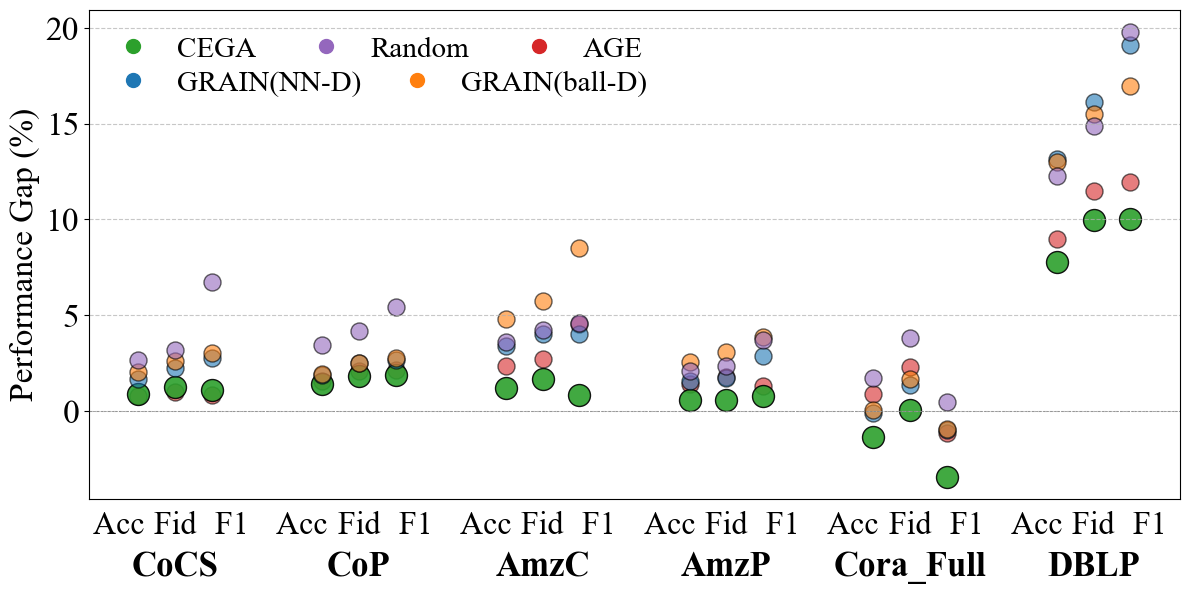

In [12]:
datasets = df["dataset"].unique()
metrics = ["Accuracy", "Fidelity", "F1"]
methods = df["selection"].unique()

plt.figure(figsize=(12, 6))

for i, dataset in enumerate(['CoCS', 'CoP', 'AmzC', 'AmzP', 'Cora_Full', 'DBLP']):
    subset = df[df["dataset"] == dataset]
    x_positions = np.arange(len(metrics)) + i * (len(metrics) + 2)  # Separate clusters

    for j, metric in enumerate(metrics):
        metric_values = subset[metric].values
        for k, value in enumerate(metric_values):
            selection = subset.iloc[k]["selection"]
            x = x_positions[j]
            y = value
            
            # Define legend labels
            label = selection if selection in ["CEGA", "AGE", "Random", "GRAIN(NN-D)", "GRAIN(ball-D)"] else ""

            plt.scatter(x, y, edgecolors='black', 
                        facecolor=color_mapping.get(selection, "gray"),  # Fallback to gray if key is missing
                        alpha=0.9 if selection == "CEGA" else 0.6,  
                        s=250 if selection == "CEGA" else 150,
                        label=label if i == 0 and j == 0 and k <= 5 else "")

    for idx, metric_label in enumerate(["Acc     ", "     Fid     ", "     F1"]):
        plt.text(x_positions[idx], -6.4, metric_label, ha='center', fontsize=23, color='black')
    
    plt.text(np.mean(x_positions), -8.6, dataset, ha='center', fontsize=25, color='black', fontweight='bold')

# Customize plot
plt.xticks([], [])  # Remove x-axis ticks
plt.ylabel("Performance Gap (%)", fontsize=24)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

# Manually create legend handles
cega_handle = mlines.Line2D([], [], color=color_mapping.get("CEGA", "gray"), marker='o', markersize=10, linestyle='None', label="CEGA")
random_handle = mlines.Line2D([], [], color=color_mapping.get("Random", "gray"), marker='o', markersize=10, linestyle='None', label="Random")
age_handle = mlines.Line2D([], [], color=color_mapping.get("AGE", "gray"), marker='o', markersize=10, linestyle='None', label="AGE")
grain_nnd_handle = mlines.Line2D([], [], color=color_mapping.get("GRAIN(NN-D)", "gray"), marker='o', markersize=10, linestyle='None', label="GRAIN(NN-D)")
grain_ball_handle = mlines.Line2D([], [], color=color_mapping.get("GRAIN(ball-D)", "gray"), marker='o', markersize=10, linestyle='None', label="GRAIN(ball-D)")

# 🔥 **First row of legend (spacing = 1.0)**
legend1 = plt.legend(
    [cega_handle, random_handle, age_handle],  
    ["CEGA", "Random", "AGE"],
    loc="upper left",  
    ncol=3,  
    fontsize=21, 
    handletextpad=0.5, 
    columnspacing=1.4,  # Spacing of first row
    frameon=False,  
    bbox_to_anchor=(-0.01, 1.)  # Slightly move the first row up
)

# 🔥 **Second row of legend (spacing = 1.3)**
legend2 = plt.legend(
    [grain_nnd_handle, grain_ball_handle],  
    ["GRAIN(NN-D)", "GRAIN(ball-D)"],
    loc="upper left",  
    ncol=2,  # Second row has two items
    fontsize=21, 
    handletextpad=0.5, 
    columnspacing=0.9,  # Spacing of second row
    frameon=False,  
    bbox_to_anchor=(-0.01, 0.93)  # Move the second row slightly down
)

# Add first row back so both legends are displayed together
plt.gca().add_artist(legend1)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./output/gaps.pdf', format='pdf', bbox_inches='tight')
plt.show()
